In [1]:
import awkward as ak
import numpy as np
import pandas as pd
import uproot
from matplotlib import pyplot as plt
#import torch
import sklearn as sk

In [2]:
f = uproot.open("trackingNtuple_0.root")["trackingNtuple/tree;3"]
df = f.arrays(library="pd")

In [3]:
temp = ak.argmax(df['trk_simTrkIdx'][0], keepdims=True, axis=-1, mask_identity=False)
DataFrameIds=[df["trk_simTrkIdx"][0][i][temp[i]][0] if temp[i]!=-1 else temp[i][0].astype(np.int32) for i in range(len(temp))]

In [4]:
Check = []
for i in range(len(DataFrameIds)):
    if ((DataFrameIds[i]>0 and df['sim_pt'][0][DataFrameIds[i]]>0.9 and abs(df['sim_eta'][0][DataFrameIds[i]])<2.4) or DataFrameIds[i]<0):
        Check.append(i)
DataFrameIds = [DataFrameIds[trk] for trk in Check]

In [5]:
d = {'truth':[], 'trk_dxy':[], 'trk_dz':[], 'trk_pt':[], 'trk_eta':[], 'trk_nChi2':[], 'trk_nPixel':[]}
DataBase = pd.DataFrame(d)
f = {'truth':[1], 'trk_dxy':[1], 'trk_dz':[1], 'trk_pt':[1], 'trk_eta':[1], 'trk_nChi2':[1], 'trk_nPixel':[1]}
count=0
for ev in range(len(df)):
    temp = ak.argmax(df['trk_simTrkIdx'][ev], keepdims=True, axis=-1, mask_identity=False)
    DataFrameIds=[df["trk_simTrkIdx"][ev][i][temp[i]][0] if temp[i]!=-1 else temp[i][0].astype(np.int32) for i in range(len(temp))]
    #print(DataFrameIds)
    #print(len(DataFrameIds))
    for i in range(len(DataFrameIds)):
        #print(i)
        if ((DataFrameIds[i]>0 and df['sim_pt'][ev][DataFrameIds[i]]>0.9 and abs(df['sim_eta'][ev][DataFrameIds[i]])<2.4) or DataFrameIds[i]<0):
            f = {'truth':[bool(DataFrameIds[i]+1)], 'trk_dxy':[df["trk_dxy"][ev][i]], 'trk_dz':[df["trk_dz"][ev][i]], 'trk_pt':[df["trk_pt"][ev][i]], 'trk_eta':[df["trk_eta"][ev][i]], 'trk_nChi2':[df["trk_nChi2"][ev][i]], 'trk_nPixel':[df["trk_nPixel"][ev][i]]}
            DataBase.loc[count]=f
            #print(ev, i, DataFrameIds[i], df["trk_dxy"][ev][i], df["trk_dz"][ev][i], df["trk_pt"][ev][i], df["trk_eta"][ev][i], df["trk_nChi2"][ev][i], df["trk_nPixel"][ev][i])
            count+=1

In [6]:
print(DataBase.shape[0])

6828


In [7]:
DataBase1=DataBase.sample(frac=1, ignore_index=True)
for el in DataBase1.columns:
    for i in range(DataBase1.shape[0]):
        DataBase1.loc[i, el]=DataBase1[el][i][0]
DataBase1

,truth,trk_dxy,trk_dz,trk_pt,trk_eta,trk_nChi2,trk_nPixel
0,True,-0.006859,-3.838256,1.075044,-2.304265,2.723219,6
1,True,-0.003341,3.690474,1.511728,0.82892,1.194373,4
2,True,0.016435,-2.699049,1.115923,0.773247,0.319626,5
3,True,0.010991,1.771263,1.067791,-0.839097,1.351105,4
4,True,0.001456,-1.621667,3.018059,-2.202502,0.16773,4
...,...,...,...,...,...,...,...
6823,True,-0.001069,-1.321757,1.477437,0.993369,0.204994,4
6824,True,-0.003063,-2.792601,2.364923,-2.235943,0.357171,4
6825,True,-0.009146,3.818731,0.976498,-2.026264,2.163177,5
6826,True,-0.002853,0.577545,1.623737,2.318349,0.179132,5


In [8]:
TrData=DataBase1.loc[:int(0.8*DataBase1.shape[0])]
ValData=DataBase1.loc[int(0.8*DataBase1.shape[0]):]

In [9]:
visualizer1 = []
visualizer2 = []
for i in range(len(TrData['truth'])):
    if TrData['truth'][i]==True:
        visualizer1.append(TrData['trk_nPixel'][i])
    else :
        visualizer2.append(TrData['trk_nPixel'][i])


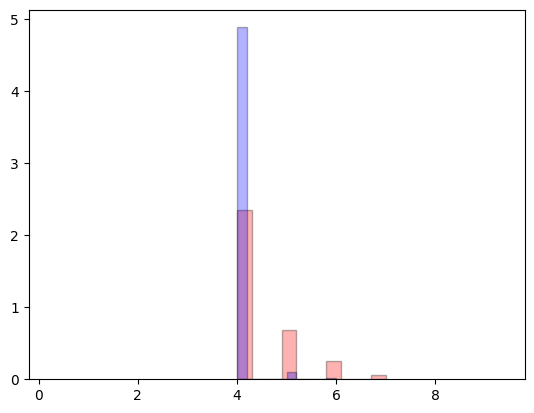

In [12]:
plt.xlim(-0.2, 9.8)
plt.hist(visualizer1, bins=10, color='red', alpha=0.3, density=True, ec="k")
plt.hist(visualizer2, bins=10, color='blue', alpha=0.3, density=True, ec="k")
plt.show()

In [13]:
data = np.zeros((TrData.shape[0], TrData.shape[1]-1))
target = np.zeros(TrData.shape[0])
for i in range(TrData.shape[0]):
    data[i, 0] = TrData['trk_dxy'][i]
    data[i, 1] = TrData['trk_dz'][i]
    data[i, 2] = TrData['trk_pt'][i]
    data[i, 3] = TrData['trk_eta'][i]
    data[i, 4] = TrData['trk_nChi2'][i]
    data[i, 5] = TrData['trk_nPixel'][i]
    target[i]  = TrData['truth'][i]

In [20]:
np.set_printoptions(threshold=np.inf)

In [22]:
weight = np.sum(target)/(len(target)-np.sum(target))
Weights = np.ones(TrData.shape[0])
for i in range(len(target)):
    if target[i]==0:
        Weights[i]=weight
#print(Weights)

In [23]:
model = sk.ensemble.GradientBoostingClassifier(n_estimators=100)
model.fit(data, target, sample_weight=Weights)

GradientBoostingClassifier()

In [16]:
#model1 = sk.tree.DecisionTreeClassifier()
#model1.fit(data,target)

In [24]:
data1 = np.zeros((ValData.shape[0], ValData.shape[1]-1))
target1 = np.zeros(ValData.shape[0])
for i in range(ValData.shape[0]):
    data1[i, 0] = ValData['trk_dxy'][TrData.shape[0]+i-1]
    data1[i, 1] = ValData['trk_dz'][TrData.shape[0]+i-1]
    data1[i, 2] = ValData['trk_pt'][TrData.shape[0]+i-1]
    data1[i, 3] = ValData['trk_eta'][TrData.shape[0]+i-1]
    data1[i, 4] = ValData['trk_nChi2'][TrData.shape[0]+i-1]
    data1[i, 5] = ValData['trk_nPixel'][TrData.shape[0]+i-1]
    target1[i]  = ValData['truth'][TrData.shape[0]+i-1]
VALPRED=model.predict(data1)
#VALPRED1=model1.predict(data1)

In [25]:
#AccTree = sk.metrics.accuracy_score(target1, VALPRED1)
AccGrad = sk.metrics.accuracy_score(target1, VALPRED)
#print(AccTree, 'AccGrad')

In [26]:
fpr, tpr, thr= sk.metrics.roc_curve(target1, VALPRED, drop_intermediate=False)

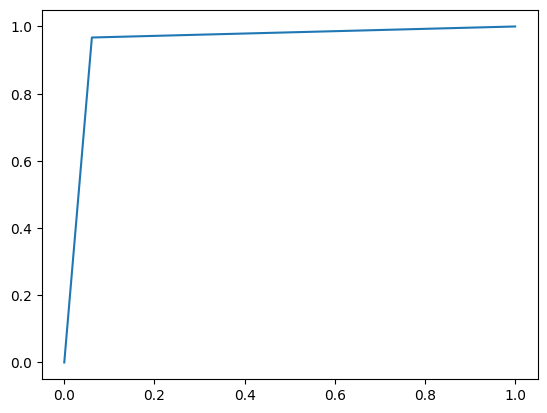

In [27]:
plt.plot(fpr, tpr)
plt.show()

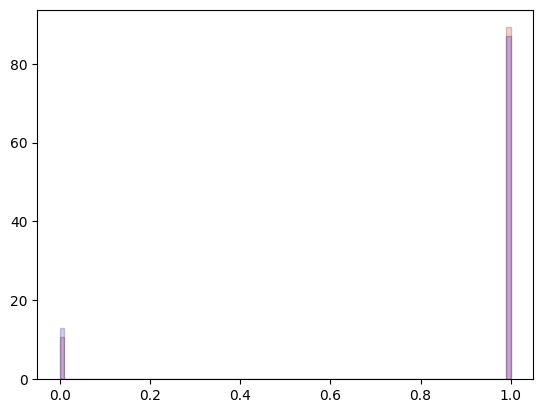

In [28]:
plt.hist(target1, bins=100, color='red', alpha=0.2, density=True, ec="k")
plt.hist(VALPRED, bins=100, color='blue', alpha=0.2, density=True, ec="k")
plt.show()

In [29]:
err=np.sum(VALPRED-target1)
print(err/np.sum(target1))

-0.02543068088597211
